# **Advanced lecture: Multi-fidelity 예측 모델 (Co-Kriging) 실습**
---


By Mingyu Lee and Ikjin Lee

http://idol.kaist.ac.kr/

mglee91@kaist.ac.kr

https://github.com/MingyuLee91

IDOL Lab at KAIST



---

### **< Source papers >**

* Le Gratiet, L. (2013). Multi-fidelity Gaussian process regression for computer experiments (Doctoral dissertation, Université Paris-Diderot-Paris VII).

* **Lee, M.**, Jung, Y., Choi, J., & Lee, I. (2022). A reanalysis-based multi-fidelity (RBMF) surrogate framework for efficient structural optimization. Computers & Structures, 273, 106895.

* **Lee, M.**, Noh, Y., & Lee, I. (2024). A novel sampling method for adaptive gradient-enhanced Kriging. Computer Methods in Applied Mechanics and Engineering, 418, 116456.

Original source codes from https://github.com/SMTorg/SMT

Modified version by Mingyu Lee

---


### **< Contents >**

1) Optimization example

2) One-dimensional example (Kriging)

**3) One-dimensional example (Co-Kriging)**

4) Engineering application (Kriging)

5) Engineering application (Co-Kriging)


# **3) One-dimensional Co-Kriging example**

## **▣ Multi-fidelity (MF) 이론 설명**

* **Surrogate model:** 입력과 출력 관계를 수학적으로 모델링하는 과정
* **Single-fidelity surrogate model:** 한가지의 충실도 데이터를 사용하여 대리모델 구성
* **Multi-fidelity surrogate model:** 다수의 충실도 데이터를 결합하여 효율적으로 대리모델 구성
<br/>**▷ Low-fidelity (LF) data:** 비교적 덜 정확하지만 값싼 데이터 (Ttrend term)
<br/>**▷ High-fidelity (HF) data:** 정확하고 비싼 데이터 (Correction term)
<br/>**▷ Types:** Co-Kriging, Hierarchical Kriging, and multi-fidelity neural networks, etc

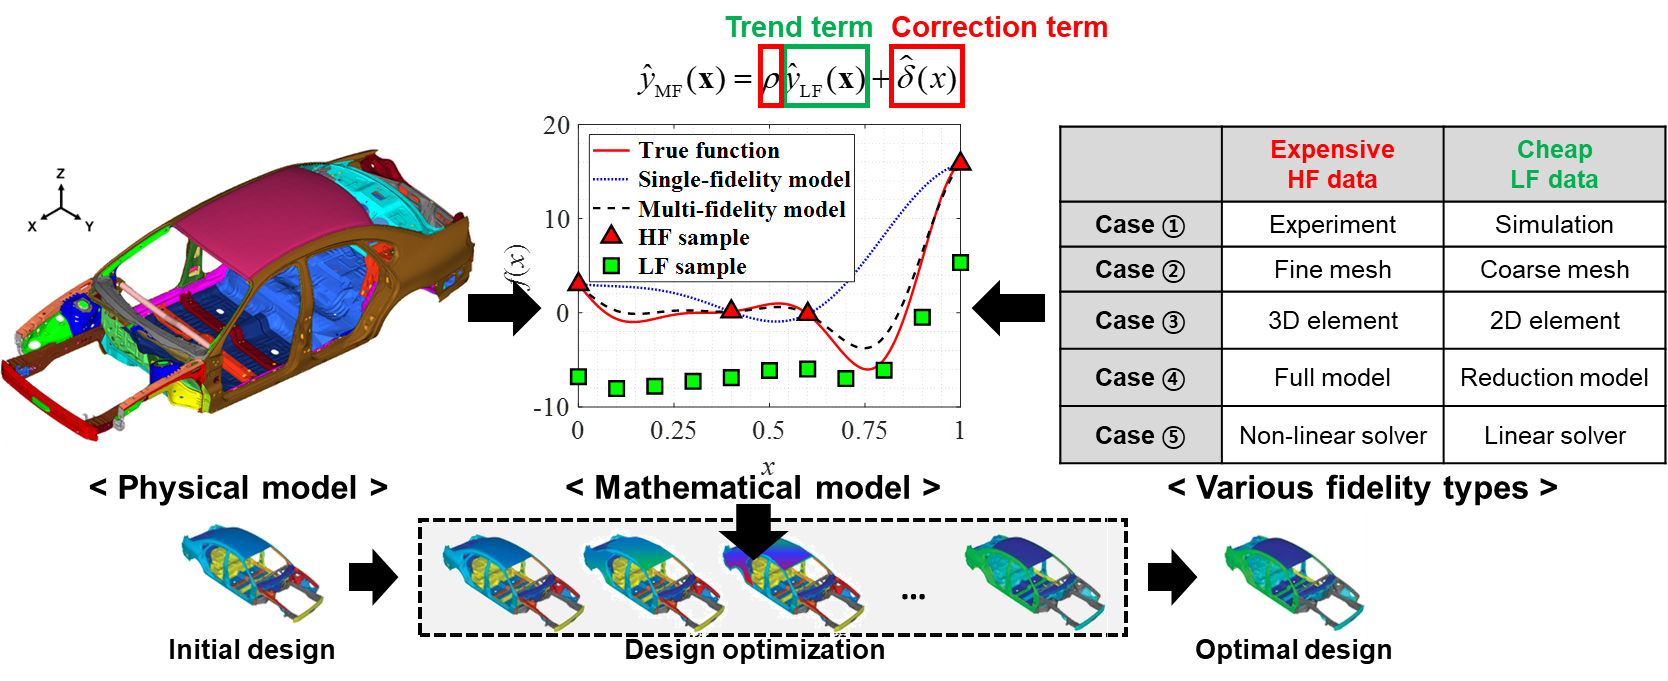

In [1]:
!pip install smt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 833.7/833.7 kB 14.7 MB/s eta 0:00:00


### ※ **예제 문제**
* 설계 공간: 0~1
* HF 함수: y<sub>HF</sub> = (6x - 2)<sup>2</sup> sin(12x - 4)
* LF 함수: y<sub>LF</sub> = 0.5y<sub>HF</sub>+10(x-0.5)-5
* HF 데이터: x=0, 0.4, 0.6, 1.0에서 입력 및 출력 값 존재
* LF 데이터: x=0, 0.2,, 0.4, 0.6, 0.8, 1.0에서 입력 및 출력 값 존재
* Co-Kriging으로 대리모델링을 수행


In [2]:
from __future__ import print_function, division
import numpy as np
from matplotlib import pyplot as plt
from smt.applications import MFK
%matplotlib inline

from scipy import linalg
from smt.utils import compute_rms_error

from smt.problems import Sphere, NdimRobotArm, Rosenbrock
from smt.sampling_methods import LHS
from smt.surrogate_models import LS, QP, KPLS, KRG, KPLSK, GEKPLS, MGP
try:
    from smt.surrogate_models import IDW, RBF, RMTC, RMTB
    compiled_available = True
except:
    compiled_available = False

try:
    import matplotlib.pyplot as plt
    plot_status = True
except:
    plot_status = False

import scipy.interpolate

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

## **Step 1: 인풋 정보 (or 전처리 과정)**

In [3]:
ndim = 1
def HF_function(x): # HF 함수
    return ((6*x-2)**2)*np.sin((6*x-2)*2)

def LF_function(x): # LF 함수
    return 0.5*((6*x-2)**2)*np.sin((6*x-2)*2)+10*(x-0.5) - 5

## **Step2: 실험계획법 (DOE)**

In [4]:
# HF 인풋 데이터
xt_HF = np.array([0.0, 0.4, 0.6, 1.])

# LF 인풋 데이터
xt_LF = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.])

In [5]:
print("HF input data",xt_HF)
print("LF input data",xt_LF)

HF input data [0.  0.4 0.6 1. ]
LF input data [0.  0.2 0.4 0.6 0.8 1. ]


## **Step 3: 데이터 생성 (시뮬레이션 or 실험)**

In [6]:
# 아웃풋 데이터 생성 (실제 시뮬레이션 혹은 실험 수행)
yt_HF = HF_function(xt_HF) # 실제 HF 아웃풋 데이터 생성
yt_LF = LF_function(xt_LF) # 실제 LF 아웃풋 데이터 생성

In [7]:
print("HF output data",yt_HF)
print("LF output data",yt_LF)

HF output data [ 3.02720998  0.11477697 -0.14943781 15.82973195]
LF output data [-8.48639501 -8.31986355 -5.94261151 -4.0747189  -4.47456522  7.91486597]


## **Step 4: 대리 모델 구성 (Co-Kriging)**

In [8]:
# 대리모델링 (Main process, Co Kriging)
initial_theta = [0.1]*ndim # 초기 하이퍼파라미터 설정
sm_MF = MFK(theta0 = initial_theta, theta_bounds = [1e-6, 20], use_het_noise = False,
         propagate_uncertainty = False, n_start = 1)
sm_MF.set_training_values(xt_LF, yt_LF, name = 0) # LF 데이터 입력
sm_MF.set_training_values(xt_HF, yt_HF) # HF 데이터 입력
sm_MF.train() # 하이퍼파라미터 최적화

___________________________________________________________________________
   
                                    MFK
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 4
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0554037


In [9]:
# 대리모델링 (Main process, Kriging)
sm_HF_only = KRG(theta0 = initial_theta)
sm_HF_only.set_training_values(xt_HF, yt_HF)
sm_HF_only.train() # 하이퍼파라미터 최적화

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 4
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.1247129


## **후처리 과정 (Multi-fidelity surrogate model vs Single-fidelity surrogate model)**

In [10]:
# 시각화 (Post-processing)
num = 100
x = np.linspace(0.0, 1.0, num).reshape(-1, 1) # 0에서 1까지 등간격으로 num개의 x값을 생성

y_true_HF = HF_function(x) # 실제 HF 값
y_true_LF = LF_function(x) # 실제 LF 값

# MF (Co Kriging)
y_MF = sm_MF.predict_values(x) # MF의 예측값
var_MF = sm_MF.predict_variances(x) # MF의 불확실 정보

# LF (Kriging) --> Co Kriging이 만들어지면서 자연스럽게 생성됨
y_LF = sm_MF._predict_intermediate_values(x, 1) # LF의 예측값
var_LF, _ =  sm_MF.predict_variances_all_levels(x) # LF의 불확실 정보

# HF (Kriging)
y_HF_only = sm_HF_only.predict_values(x) # HF의 예측값
var_HF_only = sm_HF_only.predict_variances(x) # HF의 불확실 정보

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 100
   
   Predicting ...
   Predicting - done. Time (sec):  0.0012448
   
   Prediction time/pt. (sec) :  0.0000124
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 100
   
   Predicting ...
   Predicting - done. Time (sec):  0.0100458
   
   Prediction time/pt. (sec) :  0.0001005
   


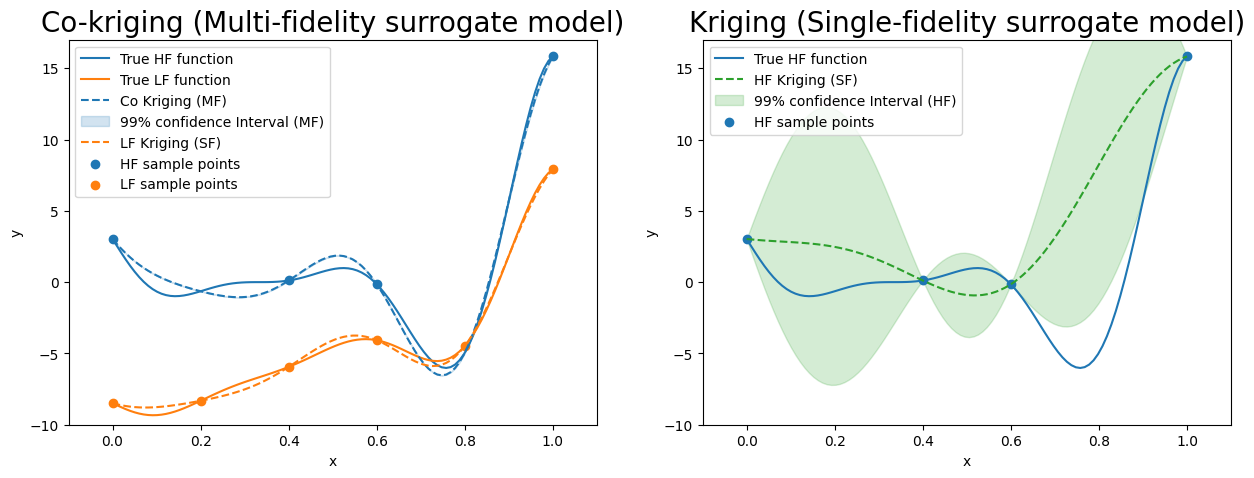

In [11]:
plt.figure(figsize = (15, 5))
plt.subplot(1,2,1)
plt.plot(x, y_true_HF, '-C0', label='True HF function')
plt.plot(x, y_true_LF, '-C1', label='True LF function')
plt.plot(x, y_MF, '--C0', label='Co Kriging (MF)')
plt.fill_between(np.ravel(x), np.ravel(y_MF-3*np.sqrt(var_MF)),
                  np.ravel(y_MF+3*np.sqrt(var_MF)),
                  color='C0',alpha=0.2, label ='99% confidence Interval (MF)')
plt.plot(x, y_LF, '--C1', label='LF Kriging (SF)')

plt.scatter(xt_HF, yt_HF, marker='o', c='C0', label='HF sample points')
plt.scatter(xt_LF, yt_LF, marker='o', c='C1', label='LF sample points')
plt.ylim(-10, 17); plt.xlim(-0.1, 1.1)
plt.xlabel('x'); plt.ylabel('y')
plt.legend()
plt.title('Co-kriging (Multi-fidelity surrogate model)',fontsize='20')

plt.subplot(1,2,2)
plt.plot(x, HF_function(x), '-C0', label='True HF function')
plt.plot(x, y_HF_only, '--C2', label='HF Kriging (SF)')
plt.fill_between(np.ravel(x), np.ravel(y_HF_only-3*np.sqrt(var_HF_only)),
                  np.ravel(y_HF_only+3*np.sqrt(var_HF_only)),
                  color='C2',alpha=0.2, label ='99% confidence Interval (HF)')

plt.scatter(xt_HF, yt_HF, marker='o', c='C0', label='HF sample points')
plt.ylim(-10, 17); plt.xlim(-0.1, 1.1)
plt.xlabel('x'); plt.ylabel('y')
plt.title('Kriging (Single-fidelity surrogate model)',fontsize='20')
plt.legend();